<a href="https://colab.research.google.com/github/Thierry-Hai-Son-ADAM/VaR_and_Backtesting_Model/blob/main/VaR_and_Backtesting_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Portfolio Analysis Tool - Google Colab Edition

Please upload your 'My Portfolio Analysis.xlsx' file


Saving Updated_Updated_My Portfolio Analysis (1)_20250515_133712 (1)_20250515_134430.xlsx to Updated_Updated_My Portfolio Analysis (1)_20250515_133712 (1)_20250515_134430 (1).xlsx
Using portfolio file: Updated_Updated_My Portfolio Analysis (1)_20250515_133712 (1)_20250515_134430 (1).xlsx
Enter the last VaR date (dd-mm-yyyy) or press Enter for today: 
Enter VaR backtesting period (days) or press Enter for 30 days: 
VaR calculation end date: 2025-05-15
VaR backtesting period: 30 days

Found 8 tickers in portfolio: RACE, MBG.DE, STLA, ML.PA, BMW.DE, VOW3.DE, RNO.PA, PAH3.DE

Portfolio value: 525.67

Retrieving asset information from Yahoo Finance...
Retrieving data for RACE...
Successfully retrieved data for RACE: Ferrari N.V.
Retrieving data for MBG.DE...
Successfully retrieved data for MBG.DE: Mercedes-Benz Group AG
Retrieving data for STLA...
Successfully retrieved data for STLA: Stellantis N.V.
Retrieving data for ML.PA...
Successfully retrieved data for ML.PA: Compagnie Générale des 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Results saved to Updated_Updated_Updated_My Portfolio Analysis (1)_20250515_133712 (1)_20250515_134430 (1)_20250515_134538.xlsx and ready for download

Calculating daily returns...

Generating VaR backtesting plot...

VaR Backtesting Results:
Monte Carlo VaR breaches: 0 (0.00%)
Historical VaR breaches: 0 (0.00%)
Expected breaches at 99% confidence: 1.00%


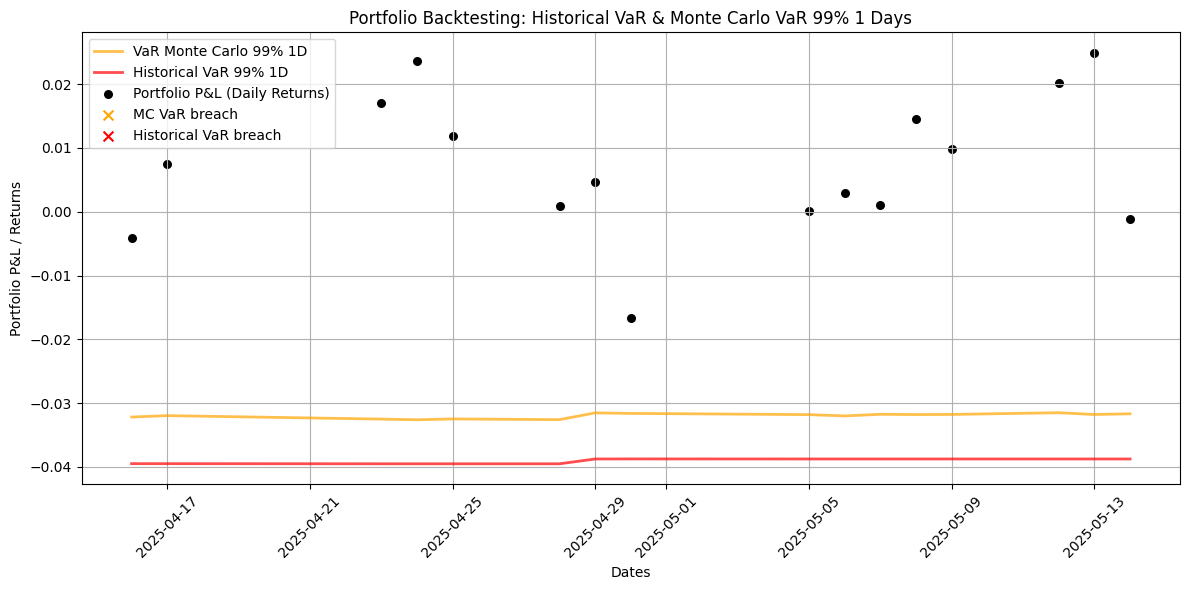


Analysis complete!


In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import openpyxl as pyxl
from openpyxl import load_workbook
from scipy.stats import norm
import os
from google.colab import files
import io

# Function to upload the Excel file
def upload_excel_file():
    print("Please upload your 'My Portfolio Analysis.xlsx' file")
    uploaded = files.upload()

    if not uploaded:
        raise Exception("No file was uploaded.")

    # Get the first file name
    file_name = list(uploaded.keys())[0]

    print(f"Using portfolio file: {file_name}")
    return file_name

# Function to retrieve asset information
def retrieve_asset_info(tickers):
    asset_info = {}
    for ticker in tickers:
        try:
            print(f"Retrieving data for {ticker}...")
            asset = yf.Ticker(ticker)
            info = asset.info

            # Get latest price from history
            historical_data = asset.history(period="1d")
            latest_close = None
            if not historical_data.empty and 'Close' in historical_data:
                latest_close = historical_data["Close"].iloc[-1]

            asset_info[ticker] = {
                'company_name': info.get('longName', 'Company name not available'),
                'country': info.get('country', 'Country info not available'),
                'industry': info.get('industry', 'Industry info not available'),
                'sector': info.get('sector', 'Sector info not available'),
                'market_cap': info.get('marketCap', 'Market value not available'),
                'latest_close': latest_close,
                'currency': info.get('currency', 'USD')
            }
            print(f"Successfully retrieved data for {ticker}: {asset_info[ticker]['company_name']}")
        except Exception as e:
            print(f"Error retrieving data for {ticker}: {e}")
            asset_info[ticker] = {
                'company_name': f"Error retrieving {ticker}",
                'country': 'N/A',
                'industry': 'N/A',
                'sector': 'N/A',
                'market_cap': 'N/A',
                'latest_close': None,
                'currency': 'USD'
            }
    return asset_info

# Function to copy data to Excel
def copy_datas(wb, asset_info):
    try:
        main_ws = wb['Portfolio Summary']

        # Read main sheet with pandas
        main_sheet_data = []
        for row in main_ws.iter_rows(values_only=True):
            main_sheet_data.append(row)
        main_sheet = pd.DataFrame(main_sheet_data[1:], columns=main_sheet_data[0])

        # Get column indices
        last_column = main_ws.max_column
        headers = ['Asset', 'Country', 'Industry', 'Sector', 'Market Cap']
        existing_headers = [main_ws.cell(row=1, column=col).value for col in range(1, last_column + 1)]

        # Get yfinance adjusted MV column index
        yf_adj_MV_column_index = None
        yf_adj_MV_header = "yfinance adjusted MV"

        if yf_adj_MV_header in existing_headers:
            yf_adj_MV_column_index = existing_headers.index(yf_adj_MV_header) + 1
        else:
            # Create the column if it doesn't exist
            yf_adj_MV_column_index = last_column + 1
            main_ws.cell(row=1, column=yf_adj_MV_column_index, value=yf_adj_MV_header)
            last_column += 1

        print(f"Headers in Excel: {existing_headers}")

        # Create headers if they don't exist
        col_offset = last_column + 1
        for header in headers:
            if header not in existing_headers:
                main_ws.cell(row=1, column=col_offset, value=header)
                col_offset += 1

        # Insert asset information for each ticker
        for row in main_ws.iter_rows(min_row=2, max_row=main_ws.max_row, min_col=2, max_col=2):
            ticker_cell = row[0]

            if not ticker_cell.value or ticker_cell.value == 'Total':
                continue

            ticker = ticker_cell.value
            quantity_cell = main_ws.cell(row=ticker_cell.row, column=3)

            if ticker not in asset_info:
                print(f"Warning: {ticker} not found in asset info")
                continue

            try:
                print(f"Processing {ticker}...")
                asset = yf.Ticker(ticker)
                currency = asset_info[ticker].get('currency')

                # Get latest price from history
                historical_data = asset.history(period="1d")
                if historical_data.empty or 'Close' not in historical_data:
                    print(f"No recent price data for {ticker}")
                    continue

                latest_close = historical_data["Close"].iloc[-1]
                print(f"Latest close for {ticker}: {latest_close}")

                # Update company information
                main_ws.cell(row=ticker_cell.row, column=1, value=asset_info[ticker].get('company_name', 'N/A'))

                # Find or create columns for country, industry, sector, market cap
                country_col = next((i for i, h in enumerate(existing_headers, 1) if h == 'Country'), 7)
                industry_col = next((i for i, h in enumerate(existing_headers, 1) if h == 'Industry'), 8)
                sector_col = next((i for i, h in enumerate(existing_headers, 1) if h == 'Sector'), 9)
                market_cap_col = next((i for i, h in enumerate(existing_headers, 1) if h == 'Market Cap'), 10)

                main_ws.cell(row=ticker_cell.row, column=country_col, value=asset_info[ticker].get('country', 'N/A'))
                main_ws.cell(row=ticker_cell.row, column=industry_col, value=asset_info[ticker].get('industry', 'N/A'))
                main_ws.cell(row=ticker_cell.row, column=sector_col, value=asset_info[ticker].get('sector', 'N/A'))
                main_ws.cell(row=ticker_cell.row, column=market_cap_col, value=asset_info[ticker].get('market_cap', 'N/A'))

                # Find price column (usually column 5)
                price_col = 5

                # Convert to EUR if necessary
                if currency and currency != 'EUR':
                    try:
                        print(f"{ticker} is priced in {currency}, converting to EUR...")
                        forex_ticker = f"{currency}EUR=X"
                        forex_data = yf.Ticker(forex_ticker)
                        forex_history = forex_data.history(period="1d")

                        if forex_history.empty or 'Close' not in forex_history:
                            print(f"No exchange rate data for {forex_ticker}")
                            exchange_rate = 1.0  # Default to 1.0 if no data
                        else:
                            exchange_rate = forex_history["Close"].iloc[-1]

                        price_in_euro = latest_close * exchange_rate

                        main_ws.cell(row=ticker_cell.row, column=price_col, value=price_in_euro)

                        if quantity_cell.value:
                            market_value = price_in_euro * quantity_cell.value
                            main_ws.cell(row=ticker_cell.row, column=yf_adj_MV_column_index, value=market_value)

                        print(f"Converted {ticker} price to EUR: {price_in_euro}")
                    except Exception as e:
                        print(f"Error converting {ticker} to EUR: {e}")
                else:
                    main_ws.cell(row=ticker_cell.row, column=price_col, value=latest_close)

                    if quantity_cell.value:
                        market_value = latest_close * quantity_cell.value
                        main_ws.cell(row=ticker_cell.row, column=yf_adj_MV_column_index, value=market_value)

            except Exception as e:
                print(f"Error processing {ticker}: {e}")

        # Calculate total for yfinance adjusted MV
        total_row = None
        for row in main_ws.iter_rows(min_row=2, max_row=main_ws.max_row, min_col=1, max_col=1):
            if row[0].value == 'Total':
                total_row = row[0].row
                break

        if total_row:
            # Sum the yfinance adjusted MV column
            total_sum = 0
            for row in range(2, total_row):
                cell_value = main_ws.cell(row=row, column=yf_adj_MV_column_index).value
                if cell_value and isinstance(cell_value, (int, float)):
                    total_sum += cell_value

            main_ws.cell(row=total_row, column=yf_adj_MV_column_index, value=total_sum)

        return wb
    except Exception as e:
        print(f"Error in copy_datas: {e}")
        raise

# Function to export historical prices to Excel
def export_close_prices(wb, close_adj_df):
    try:
        # Create new sheet name
        sheet_name = 'Historical Prices'

        # Check if sheet already exists and remove it
        if sheet_name in wb.sheetnames:
            wb.remove(wb[sheet_name])

        # Create new sheet
        prices_sheet = wb.create_sheet(sheet_name)

        # Write the dates as first column
        prices_sheet.cell(row=1, column=1, value='Date')
        for idx, date in enumerate(close_adj_df.index, start=2):
            prices_sheet.cell(row=idx, column=1, value=date.strftime('%Y-%m-%d'))

        # Write the ticker names as headers
        for col, ticker in enumerate(close_adj_df.columns, start=2):
            prices_sheet.cell(row=1, column=col, value=ticker)

        # Write the price data
        for col, ticker in enumerate(close_adj_df.columns, start=2):
            for row, price in enumerate(close_adj_df[ticker], start=2):
                prices_sheet.cell(row=row, column=col, value=price)

        return prices_sheet
    except Exception as e:
        print(f"Error in export_close_prices: {e}")
        raise

# Function to perform VaR backtesting
def perform_var_backtesting(tickers, combined_data_df, settings, ptf_value, user_date, user_VaR_range):
    try:
        # Create equal weights for portfolio
        weights = np.array([1/len(tickers)]*len(tickers))

        # Get settings
        days = settings['VaR Horizon (in days)'].iloc[0]
        confidence_level = settings['VaR percentile'].iloc[0]
        simulation = settings['Simulation Number'].iloc[0]

        # Create lists to store results
        mc_var_results = []
        historical_var_results = []
        dates = []

        print(f"Starting VaR backtesting for {user_VaR_range} days...")

        for i in range(user_VaR_range):
            if i % 10 == 0:  # Print progress every 10 days
                print(f"Processing day {i+1} of {user_VaR_range}...")

            # Set date range for this iteration
            end_date = user_date - dt.timedelta(days=i)
            start_date = end_date - dt.timedelta(days=365)  # Use 1 year of data for each calculation

            # Get price data for this date range
            close_adj_df = pd.DataFrame()
            for ticker in tickers:
                ticker_series = combined_data_df[ticker].loc[start_date:end_date]
                close_adj_df[ticker] = ticker_series

            # Skip if we don't have enough data
            if close_adj_df.shape[0] < 2:
                print(f"Not enough data for {end_date}, skipping...")
                continue

            # Calculate daily log returns
            log_returns = np.log(close_adj_df / close_adj_df.shift(1)).dropna()

            # Skip if we don't have enough return data
            if log_returns.empty:
                print(f"No return data for {end_date}, skipping...")
                continue

            # Calculate covariance matrix
            cov_matrix = log_returns.cov()

            # Calculate expected return
            ptf_expected_return = np.sum(log_returns.mean() * weights)

            # Calculate portfolio standard deviation
            variance = weights.T @ cov_matrix @ weights
            ptf_std_dev = np.sqrt(variance)

            # Monte Carlo VaR calculation
            scenario_returns = []
            for _ in range(simulation):
                z_score = np.random.normal(0, 1)
                scenario_return = ptf_value * ptf_expected_return + ptf_value * ptf_std_dev * z_score
                scenario_returns.append(scenario_return)

            # Calculate VaR
            var_mc = np.percentile(scenario_returns, 100 * (1 - confidence_level))
            var_mc_percentage = var_mc / ptf_value

            mc_var_results.append(var_mc_percentage)

            # Historical VaR calculation
            portfolio_returns = log_returns.dot(weights)
            hist_var = np.percentile(portfolio_returns, (1 - confidence_level) * 100)

            historical_var_results.append(hist_var)
            dates.append(end_date)

        # Create results DataFrame
        var_df = pd.DataFrame({
            'MC VaR': mc_var_results,
            'Historical VaR': historical_var_results
        }, index=pd.to_datetime(dates))

        return var_df, dates
    except Exception as e:
        print(f"Error in perform_var_backtesting: {e}")
        raise

# Main function
def main():
    try:
        print("Portfolio Analysis Tool - Google Colab Edition")
        print("==============================================\n")

        # Upload Excel file
        file_excl = upload_excel_file()

        # Get user inputs for VaR calculation
        try:
            user_date_str = input("Enter the last VaR date (dd-mm-yyyy) or press Enter for today: ")
            if user_date_str:
                user_date = pd.to_datetime(user_date_str, format="%d-%m-%Y")
            else:
                user_date = dt.datetime.now()

            user_VaR_range_str = input("Enter VaR backtesting period (days) or press Enter for 30 days: ")
            user_VaR_range = int(user_VaR_range_str) if user_VaR_range_str else 30
        except Exception as e:
            print(f"Error with user input: {e}. Using default values.")
            user_date = dt.datetime.now()
            user_VaR_range = 30

        print(f"VaR calculation end date: {user_date.strftime('%Y-%m-%d')}")
        print(f"VaR backtesting period: {user_VaR_range} days\n")

        # Load the workbook
        wb = load_workbook(file_excl, data_only=True)

        # Check for required sheets
        required_sheets = ['Portfolio Summary', 'Settings']
        for sheet in required_sheets:
            if sheet not in wb.sheetnames:
                print(f"Error: Required sheet '{sheet}' not found in the workbook.")
                return

        # Read data from Excel using pandas
        data = {}

        # Convert Excel sheets to DataFrame
        for sheet in required_sheets:
            sheet_data = []
            ws = wb[sheet]
            for row in ws.iter_rows(values_only=True):
                sheet_data.append(row)
            data[sheet] = pd.DataFrame(sheet_data[1:], columns=sheet_data[0])

        main_sheet = data['Portfolio Summary']
        settings_sheet = data['Settings']

        # Extract tickers and quantities
        ticker_col_idx = None
        for i, header in enumerate(main_sheet.columns):
            if header == 'Ticker':
                ticker_col_idx = i
                break

        if ticker_col_idx is None:
            print("Error: 'Ticker' column not found in Portfolio Summary sheet.")
            return

        tickers = main_sheet.iloc[:, ticker_col_idx].dropna().tolist()

        # Remove 'Total' if it's in the tickers list
        if 'Total' in tickers:
            tickers.remove('Total')

        if not tickers:
            print("Error: No tickers found in the portfolio.")
            return

        print(f"Found {len(tickers)} tickers in portfolio: {', '.join(tickers)}\n")

        # Get portfolio value
        asset_col_idx = None
        market_val_col_idx = None

        for i, header in enumerate(main_sheet.columns):
            if header == 'Asset':
                asset_col_idx = i
            elif header == 'Market Value':
                market_val_col_idx = i

        if asset_col_idx is None or market_val_col_idx is None:
            print("Warning: 'Asset' or 'Market Value' columns not found. Using sum of individual values.")
            if market_val_col_idx is not None:
                total_rows = main_sheet[main_sheet.iloc[:, asset_col_idx] == 'Total']
                if not total_rows.empty:
                    ptf_value = total_rows.iloc[0, market_val_col_idx]
                else:
                    ptf_value = main_sheet.iloc[:, market_val_col_idx].sum()
            else:
                print("Error: Market Value column not found. Cannot determine portfolio value.")
                return
        else:
            total_rows = main_sheet[main_sheet.iloc[:, asset_col_idx] == 'Total']
            if not total_rows.empty:
                ptf_value = total_rows.iloc[0, market_val_col_idx]
            else:
                ptf_value = main_sheet.iloc[:, market_val_col_idx].sum()

        print(f"Portfolio value: {ptf_value:.2f}\n")

        # Retrieve asset information
        print("Retrieving asset information from Yahoo Finance...")
        asset_info = retrieve_asset_info(tickers)

        # Update Excel with asset information
        print("\nUpdating Excel with asset information...")
        wb = copy_datas(wb, asset_info)

        # Download historical data for VaR calculation
        print("\nDownloading historical price data...")

        # Get required years of history
        var_range_col_idx = None
        for i, header in enumerate(settings_sheet.columns):
            if header == 'VaR range (in years)':
                var_range_col_idx = i
                break

        years = int(settings_sheet.iloc[0, var_range_col_idx]) if var_range_col_idx is not None else 5

        # Calculate the earliest date needed for the analysis
        earliest_date = user_date - dt.timedelta(days=int(years) * 365 + user_VaR_range)

        print(f"Retrieving historical data from {earliest_date.strftime('%Y-%m-%d')} to {user_date.strftime('%Y-%m-%d')}...")

        # Download data for all tickers
        combined_data_df = pd.DataFrame()
        for ticker in tickers:
            try:
                print(f"Downloading historical data for {ticker}...")
                df = yf.download(ticker, start=earliest_date, end=user_date, progress=False)
                if df.empty:
                    print(f"No historical data available for {ticker}")
                    continue
                combined_data_df[ticker] = df['Close']
            except Exception as e:
                print(f"Error downloading data for {ticker}: {e}")

        if combined_data_df.empty:
            print("Error: No historical price data available. Cannot perform VaR analysis.")
            return

        # Create or update Historical_VaR_Results and MC_VaR_Results sheets
        if 'Historical_VaR_Results' in wb.sheetnames:
            wb.remove(wb['Historical_VaR_Results'])
        his_var_ws = wb.create_sheet('Historical_VaR_Results')
        his_var_ws.cell(row=1, column=1, value='Date')
        his_var_ws.cell(row=1, column=2, value='Historical_VaR_99')

        if 'MC_VaR_Results' in wb.sheetnames:
            wb.remove(wb['MC_VaR_Results'])
        mc_var_ws = wb.create_sheet('MC_VaR_Results')
        mc_var_ws.cell(row=1, column=1, value='Date')
        mc_var_ws.cell(row=1, column=2, value='MC_VaR_99')

        # Get settings for VaR calculation
        var_horizon_col_idx = None
        var_percentile_col_idx = None
        simulation_num_col_idx = None

        for i, header in enumerate(settings_sheet.columns):
            if header == 'VaR Horizon (in days)':
                var_horizon_col_idx = i
            elif header == 'VaR percentile':
                var_percentile_col_idx = i
            elif header == 'Simulation Number':
                simulation_num_col_idx = i

        # Create a settings dataframe for backtesting
        settings = pd.DataFrame({
            'VaR Horizon (in days)': [1 if var_horizon_col_idx is None else settings_sheet.iloc[0, var_horizon_col_idx]],
            'VaR percentile': [0.99 if var_percentile_col_idx is None else settings_sheet.iloc[0, var_percentile_col_idx]],
            'Simulation Number': [10000 if simulation_num_col_idx is None else settings_sheet.iloc[0, simulation_num_col_idx]]
        })

        # Perform VaR backtesting
        print("\nPerforming VaR backtesting...")
        var_df, dates = perform_var_backtesting(tickers, combined_data_df, settings, ptf_value, user_date, user_VaR_range)

        # Write VaR results to Excel
        print("Writing VaR results to Excel...")
        for i, (date, mc_var, hist_var) in enumerate(zip(dates, var_df['MC VaR'], var_df['Historical VaR'])):
            row_idx = i + 2

            # MC VaR results
            mc_var_ws.cell(row=row_idx, column=1, value=date.strftime('%Y-%m-%d'))
            mc_var_ws.cell(row=row_idx, column=2, value=mc_var)

            # Historical VaR results
            his_var_ws.cell(row=row_idx, column=1, value=date.strftime('%Y-%m-%d'))
            his_var_ws.cell(row=row_idx, column=2, value=hist_var)

        # Export historical prices
        end_date = user_date
        start_date = end_date - dt.timedelta(days=365)
        close_adj_df = pd.DataFrame()

        for ticker in tickers:
            if ticker in combined_data_df:
                close_adj_df[ticker] = combined_data_df[ticker].loc[start_date:end_date]

        if not close_adj_df.empty:
            print("Exporting historical prices to Excel...")
            export_close_prices(wb, close_adj_df)

        # Save updated workbook
        output = io.BytesIO()
        wb.save(output)
        output.seek(0)

        # Generate new filename with timestamp
        timestamp = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
        new_filename = f"Updated_{file_excl.split('.')[0]}_{timestamp}.xlsx"

        # Create a downloadable Excel file
        with open(new_filename, 'wb') as f:
            f.write(output.getvalue())

        # Download the file
        files.download(new_filename)
        print(f"✓ Results saved to {new_filename} and ready for download")

        # Calculate daily returns for plotting
        print("\nCalculating daily returns...")
        weights = np.array([1/len(tickers)]*len(tickers))
        daily_returns = ((combined_data_df / combined_data_df.shift(1)) - 1).dropna()
        ptf_daily_returns = daily_returns.dot(weights).dropna()

        ptf_daily_returns.index = pd.to_datetime(ptf_daily_returns.index)
        var_df.index = var_df.index.normalize()
        ptf_daily_returns.index = ptf_daily_returns.index.normalize()

        # Find common dates between VaR and daily returns
        common_index = var_df.index.intersection(ptf_daily_returns.index)
        var_df = var_df.loc[common_index]
        ptf_daily_returns = ptf_daily_returns.loc[common_index]

        # Create final DataFrame for analysis
        final_df = pd.DataFrame({
            'VaR Monte Carlo': var_df['MC VaR'],
            'Historical VaR': var_df['Historical VaR'],
            'P&L': ptf_daily_returns
        })

        # Plot VaR and daily portfolio returns
        print("\nGenerating VaR backtesting plot...")
        confidence_level = settings['VaR percentile'].iloc[0]
        days = settings['VaR Horizon (in days)'].iloc[0]

        MC_NOT_breach = final_df['P&L'] > final_df['VaR Monte Carlo']
        Hist_NOT_breach = final_df['P&L'] > final_df['Historical VaR']

        plt.figure(figsize=(12, 6))

        plt.plot(final_df.index, final_df['VaR Monte Carlo'], color='orange', linestyle='-', linewidth=2,
                 label=f'VaR Monte Carlo {confidence_level*100:.0f}% {days}D', alpha=0.7)

        plt.plot(final_df.index, final_df['Historical VaR'], color='red', linestyle="-", linewidth=2,
                 label=f"Historical VaR {confidence_level*100:.0f}% {days}D", alpha=0.7)

        plt.scatter(final_df.index[MC_NOT_breach], final_df['P&L'][MC_NOT_breach], color='black', s=30,
                    label='Portfolio P&L (Daily Returns)')

        MC_breaches = final_df['P&L'] < final_df['VaR Monte Carlo']
        Historical_breaches = final_df['P&L'] < final_df['Historical VaR']

        plt.scatter(final_df.index[MC_breaches], final_df['P&L'][MC_breaches], color='orange', s=50,
                    marker='x', label='MC VaR breach')

        plt.scatter(final_df.index[Historical_breaches], final_df['P&L'][Historical_breaches], color='red',
                    s=50, marker="x", label='Historical VaR breach')

        plt.title(f'Portfolio Backtesting: Historical VaR & Monte Carlo VaR {confidence_level*100:.0f}% {days} Days')
        plt.xlabel('Dates')
        plt.ylabel('Portfolio P&L / Returns')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()

        # Calculate breach statistics
        mc_breach_count = MC_breaches.sum()
        mc_breach_pct = (mc_breach_count / len(final_df)) * 100

        hist_breach_count = Historical_breaches.sum()
        hist_breach_pct = (hist_breach_count / len(final_df)) * 100

        print("\nVaR Backtesting Results:")
        print(f"Monte Carlo VaR breaches: {mc_breach_count} ({mc_breach_pct:.2f}%)")
        print(f"Historical VaR breaches: {hist_breach_count} ({hist_breach_pct:.2f}%)")
        print(f"Expected breaches at {confidence_level*100:.0f}% confidence: {(1-confidence_level)*100:.2f}%")

        # Save and display the plot
        #plt.savefig('VaR_Backtesting_Results.png')
        #print("Plot saved as 'VaR_Backtesting_Results.png'")

        # Download the plot
        #files.download('VaR_Backtesting_Results.png')
        #print("✓ Plot downloaded")

        # Display the plot in the notebook
        plt.show()

        print("\nAnalysis complete!")

    except Exception as e:
        print(f"Error in main function: {e}")
        import traceback
        traceback.print_exc()

# Installation section - uncomment if needed
# !pip install yfinance pandas numpy matplotlib openpyxl scipy

# Run the main function
if __name__ == "__main__":
    main()